In [2]:
!pip install xgboost

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score

from xgboost import XGBClassifier, plot_importance

In [5]:
house_data = pd.read_csv("../preprocessed_data/oneHot_data.csv")

In [6]:
house_data.head()

,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,HourofDay,HvacMode_heat,...,Schedule_Home,Schedule_Sleep,T_ctrl,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,T_out,RH_out
0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,...,0,1,0.311691,0.663321,0.177458,0,11,0.330465,0.009112,1.808865
1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,...,0,1,0.311691,0.663321,0.177458,2,9,0.330465,0.009112,1.808865
2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,...,0,1,0.311691,0.663321,0.177458,20,20,0.330465,0.009112,1.808865
3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,...,0,1,0.311691,0.663321,0.177458,9,12,0.330465,0.009112,1.808865
4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,...,0,1,0.311691,0.663321,0.177458,0,8,0.330465,0.009112,1.808865


In [7]:
working_df = house_data[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

In [8]:
working_df.head()

,T_ctrl,T_stp_heat,T_out,RH_out,auxHeat1
0,0.311691,0.663321,0.009112,1.808865,0
1,0.311691,0.663321,0.009112,1.808865,2
2,0.311691,0.663321,0.009112,1.808865,20
3,0.311691,0.663321,0.009112,1.808865,9
4,0.311691,0.663321,0.009112,1.808865,0


In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# House 1 - 30 Min Time Lag

In [10]:
reframed = series_to_supervised(working_df, 6, 1)

In [11]:
y_auxHeat = reframed['var5(t)']
#y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

In [13]:
X_train = X_train.values
X_test = X_test.values

In [14]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(47064, 34) (47064,) (11767, 34) (11767,)


In [15]:
model = XGBClassifier()

In [16]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
y_predicted = model.predict(X_test)

In [21]:
cm = confusion_matrix(y_test, y_predicted)

In [23]:
cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [29]:
test_sum = 0
for i in y_test:
    test_sum += (i * 15)

In [30]:
test_sum

777660

In [31]:
predicted_sum = 0
for i in y_predicted:
    predicted_sum += (i * 15)

In [32]:
predicted_sum

754605

In [33]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 2.9646632204305225 %


In [34]:
f1_score(y_test, y_predicted, average = 'weighted')

0.8229307778160205

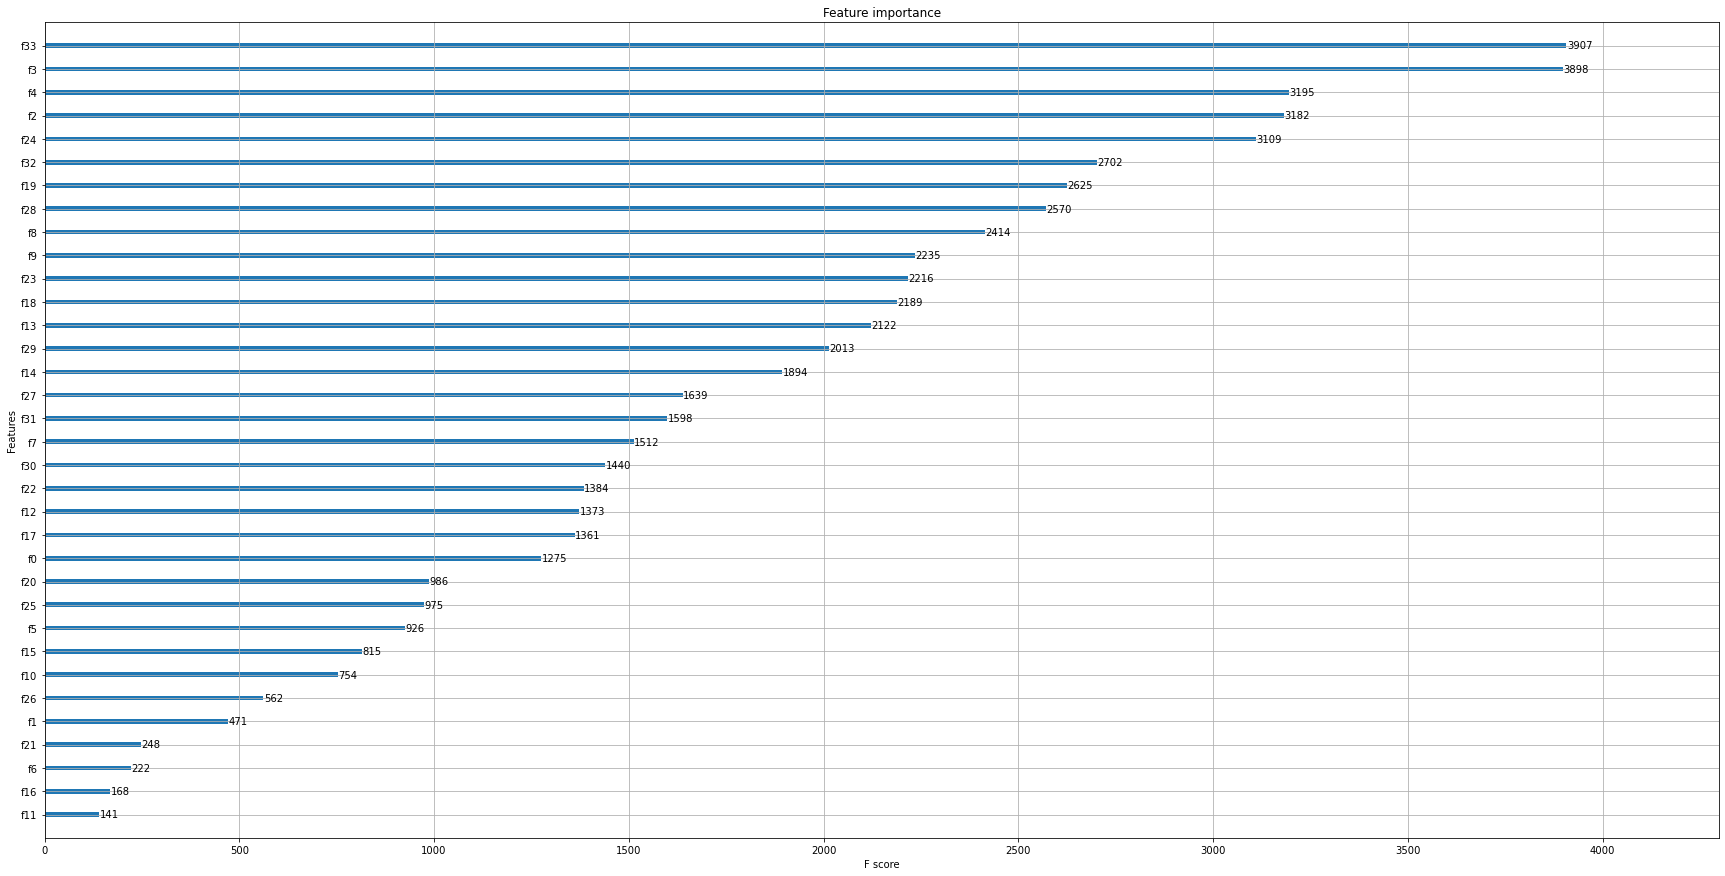

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (30, 15))
plot_importance(model, ax = ax)
plt.show()

In [40]:
working_df.head()

,T_ctrl,T_stp_heat,T_out,RH_out,auxHeat1
0,0.311691,0.663321,0.009112,1.808865,0
1,0.311691,0.663321,0.009112,1.808865,2
2,0.311691,0.663321,0.009112,1.808865,20
3,0.311691,0.663321,0.009112,1.808865,9
4,0.311691,0.663321,0.009112,1.808865,0


In [41]:
reframed.head()

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
6,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.009112,1.808865,2.0,...,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.075007,1.877919,0
7,0.311691,0.663321,0.009112,1.808865,2.0,0.311691,0.663321,0.009112,1.808865,20.0,...,0.311691,0.663321,0.075007,1.877919,0.0,0.311691,0.663321,0.075007,1.877919,0
8,0.311691,0.663321,0.009112,1.808865,20.0,0.311691,0.663321,0.009112,1.808865,9.0,...,0.311691,0.663321,0.075007,1.877919,0.0,0.311691,0.663321,0.075007,1.877919,14
9,0.311691,0.663321,0.009112,1.808865,9.0,0.311691,0.663321,0.009112,1.808865,0.0,...,0.311691,0.663321,0.075007,1.877919,14.0,0.311691,0.663321,0.075007,1.877919,19
10,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.009112,1.808865,0.0,...,0.311691,0.663321,0.075007,1.877919,19.0,0.311691,0.663321,0.075007,1.877919,0


# House 1 - 60 Min Time Lag

In [42]:
reframed = series_to_supervised(working_df, 12, 1)

In [43]:
y_auxHeat = reframed['var5(t)']
#y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

In [45]:
X_train = X_train.values
X_test = X_test.values

In [46]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(47060, 64) (47060,) (11765, 64) (11765,)


In [47]:
model = XGBClassifier()

In [48]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
y_predicted = model.predict(X_test)

In [50]:
cm = confusion_matrix(y_test, y_predicted)

cfm_n = np.flipud(cm)
cfm_n = cfm_n.astype('float') / cfm_n.sum(axis=1)[:, np.newaxis]

z = np.round(cfm_n, 2)
#x = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
y = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
#y = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
x = ['20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']
#x = ['1', '0']
#y = ['0', '1']
fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z, colorscale = 'deep')
fig.update_layout(width = 1600, height = 1600, xaxis_showgrid = False, yaxis_showgrid = False, template = 'none')
fig.update_layout(title = {'text': "",
                           'y':0.95,
                           'x':0.47,
                           'xanchor': 'center',
                           'yanchor': 'top'}, 
                  xaxis_title = 'Predicted Labels',
                  yaxis_title = 'True Labels')
fig['layout']['xaxis']['side'] = 'bottom'
fig.show()

In [51]:
test_sum = 0
for i in y_test:
    test_sum += (i * 15)

In [52]:
test_sum

783225

In [53]:
predicted_sum = 0
for i in y_predicted:
    predicted_sum += (i * 15)

In [54]:
predicted_sum

754080

In [55]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 3.721152925404577 %


In [56]:
f1_score(y_test, y_predicted, average = 'weighted')

0.8239534788892485

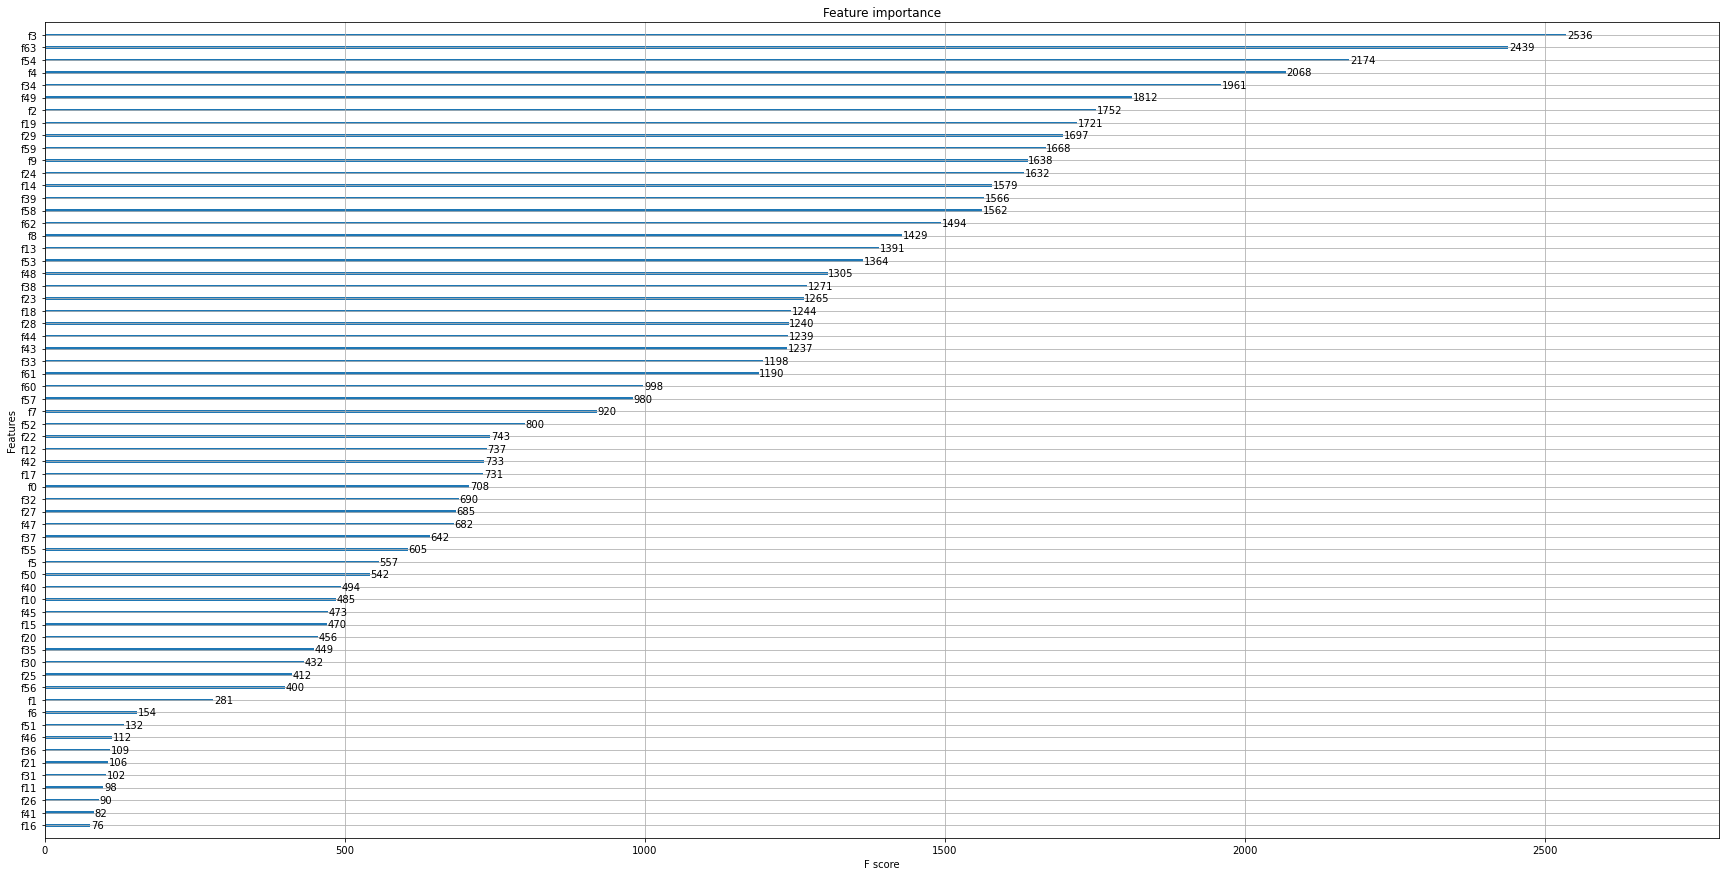

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (30, 15))
plot_importance(model, ax = ax)
plt.show()

In [58]:
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
12,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.009112,1.808865,2.0,...,0.311691,0.663321,0.075007,1.877919,0.0,0.311691,0.663321,0.075007,1.739811,0
13,0.311691,0.663321,0.009112,1.808865,2.0,0.311691,0.663321,0.009112,1.808865,20.0,...,0.311691,0.663321,0.075007,1.739811,0.0,0.311691,0.663321,0.075007,1.739811,0
14,0.311691,0.663321,0.009112,1.808865,20.0,0.311691,0.663321,0.009112,1.808865,9.0,...,0.311691,0.663321,0.075007,1.739811,0.0,0.311691,0.663321,0.075007,1.739811,4
15,0.311691,0.663321,0.009112,1.808865,9.0,0.311691,0.663321,0.009112,1.808865,0.0,...,0.311691,0.663321,0.075007,1.739811,4.0,0.311691,0.663321,0.075007,1.739811,20
16,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.009112,1.808865,0.0,...,0.311691,0.663321,0.075007,1.739811,20.0,0.311691,0.663321,0.075007,1.739811,14
